# <center> Кластеризация 4-х канальных электромиографий </center>


Изучение методов возможности кластеризовать ЭМГ различных людей, выполняющие 10 различных действий, по 5 поаторений. Всего данные есть по 40 людям, всего 2000 семплов.

Все эксперименты проводятся на датасете https://data.mendeley.com/datasets/ckwc76xr2z/2

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from loguru import logger

import os
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
import scipy


In [57]:
fs = 2000 # Hz
lenght = 1280000 
print(f"В каждом наборе данных запись на {lenght/fs} секунд по 5 повторений, по 10 жестов")

В каждом наборе данных запись на 640.0 секунд по 5 повторений, по 10 жестов


### Предобработка данных

In [88]:
# данные собраны с высокой частотой (2000 Hz) и сильно зашумлены. 
# В качестве первого приближения попробуем брать каждые data_granularity точек из каждого ряда
data_granularity = 20

labels = ['EMG_Filtred_CH1', 'EMG_Filtred_CH2', 'EMG_Filtred_CH3', 'EMG_Filtred_CH4']
df = pd.DataFrame(columns = ["human_n", "gesture", "rep"] + labels)
path = "/Users/zugzvangg/Downloads/ckwc76xr2z-2/sEMG-dataset/raw/mat/"
# CHANNEL_TO_FIT = "EMG_Filtred_CH1"
CHANNEL_TO_FIT = "EMG_Filtred_CH4"

mySeries = []
namesofMySeries = []

gestures_mapping = {
            0: "REST",
            1: "EXTENSION",
            2: "FLEXION",
            3: "ULNAR DEVIATION",
            4: "RADIAL DEVIATION",
            5: "GRIP",
            6: "ABDUCTION",
            7: "ADDUCTION",
            8: "SUPINATION",
            9: "PRONATION"}

for i in range(1, 41):
# for i in range(1, 5):
    data = scipy.io.loadmat(path + f"{i}_raw.mat")["data"]
    for rep in range(0, 5):
        if rep==0:
            rep_coeff=4
        elif rep==1:
            rep_coeff=138
        elif rep==2:
            rep_coeff=272
        elif rep==3:
            rep_coeff=406
        elif rep==4:
            rep_coeff=540
        for gesture in range(0, 10):
            
            start_index = (0 + rep_coeff + (gesture * 10)) * fs + 1
            end_index = ((rep_coeff + (gesture * 10)) + 6) * fs
            data_tmp = data[start_index: end_index]
            df_tmp = pd.DataFrame(columns = labels, data = data_tmp)

            mySeries.append(df_tmp[CHANNEL_TO_FIT].values[::data_granularity])
            namesofMySeries.append(f"{gestures_mapping[gesture]}_person{i}_rep{rep}")
            
    logger.info(f"Processed id = {i}")
     
                    


2024-04-26 22:28:35.196 | INFO     | __main__:<cell line: 26>:50 - Processed id = 1
2024-04-26 22:28:35.266 | INFO     | __main__:<cell line: 26>:50 - Processed id = 2
2024-04-26 22:28:35.334 | INFO     | __main__:<cell line: 26>:50 - Processed id = 3
2024-04-26 22:28:35.405 | INFO     | __main__:<cell line: 26>:50 - Processed id = 4
2024-04-26 22:28:35.476 | INFO     | __main__:<cell line: 26>:50 - Processed id = 5
2024-04-26 22:28:35.545 | INFO     | __main__:<cell line: 26>:50 - Processed id = 6
2024-04-26 22:28:35.617 | INFO     | __main__:<cell line: 26>:50 - Processed id = 7
2024-04-26 22:28:35.686 | INFO     | __main__:<cell line: 26>:50 - Processed id = 8
2024-04-26 22:28:35.756 | INFO     | __main__:<cell line: 26>:50 - Processed id = 9
2024-04-26 22:28:35.822 | INFO     | __main__:<cell line: 26>:50 - Processed id = 10
2024-04-26 22:28:35.895 | INFO     | __main__:<cell line: 26>:50 - Processed id = 11
2024-04-26 22:28:35.966 | INFO     | __main__:<cell line: 26>:50 - Process

In [89]:
print("Всего семплов:", len(namesofMySeries))

Всего семплов: 2000


### Примеры обработанных ЭМГ из датасета

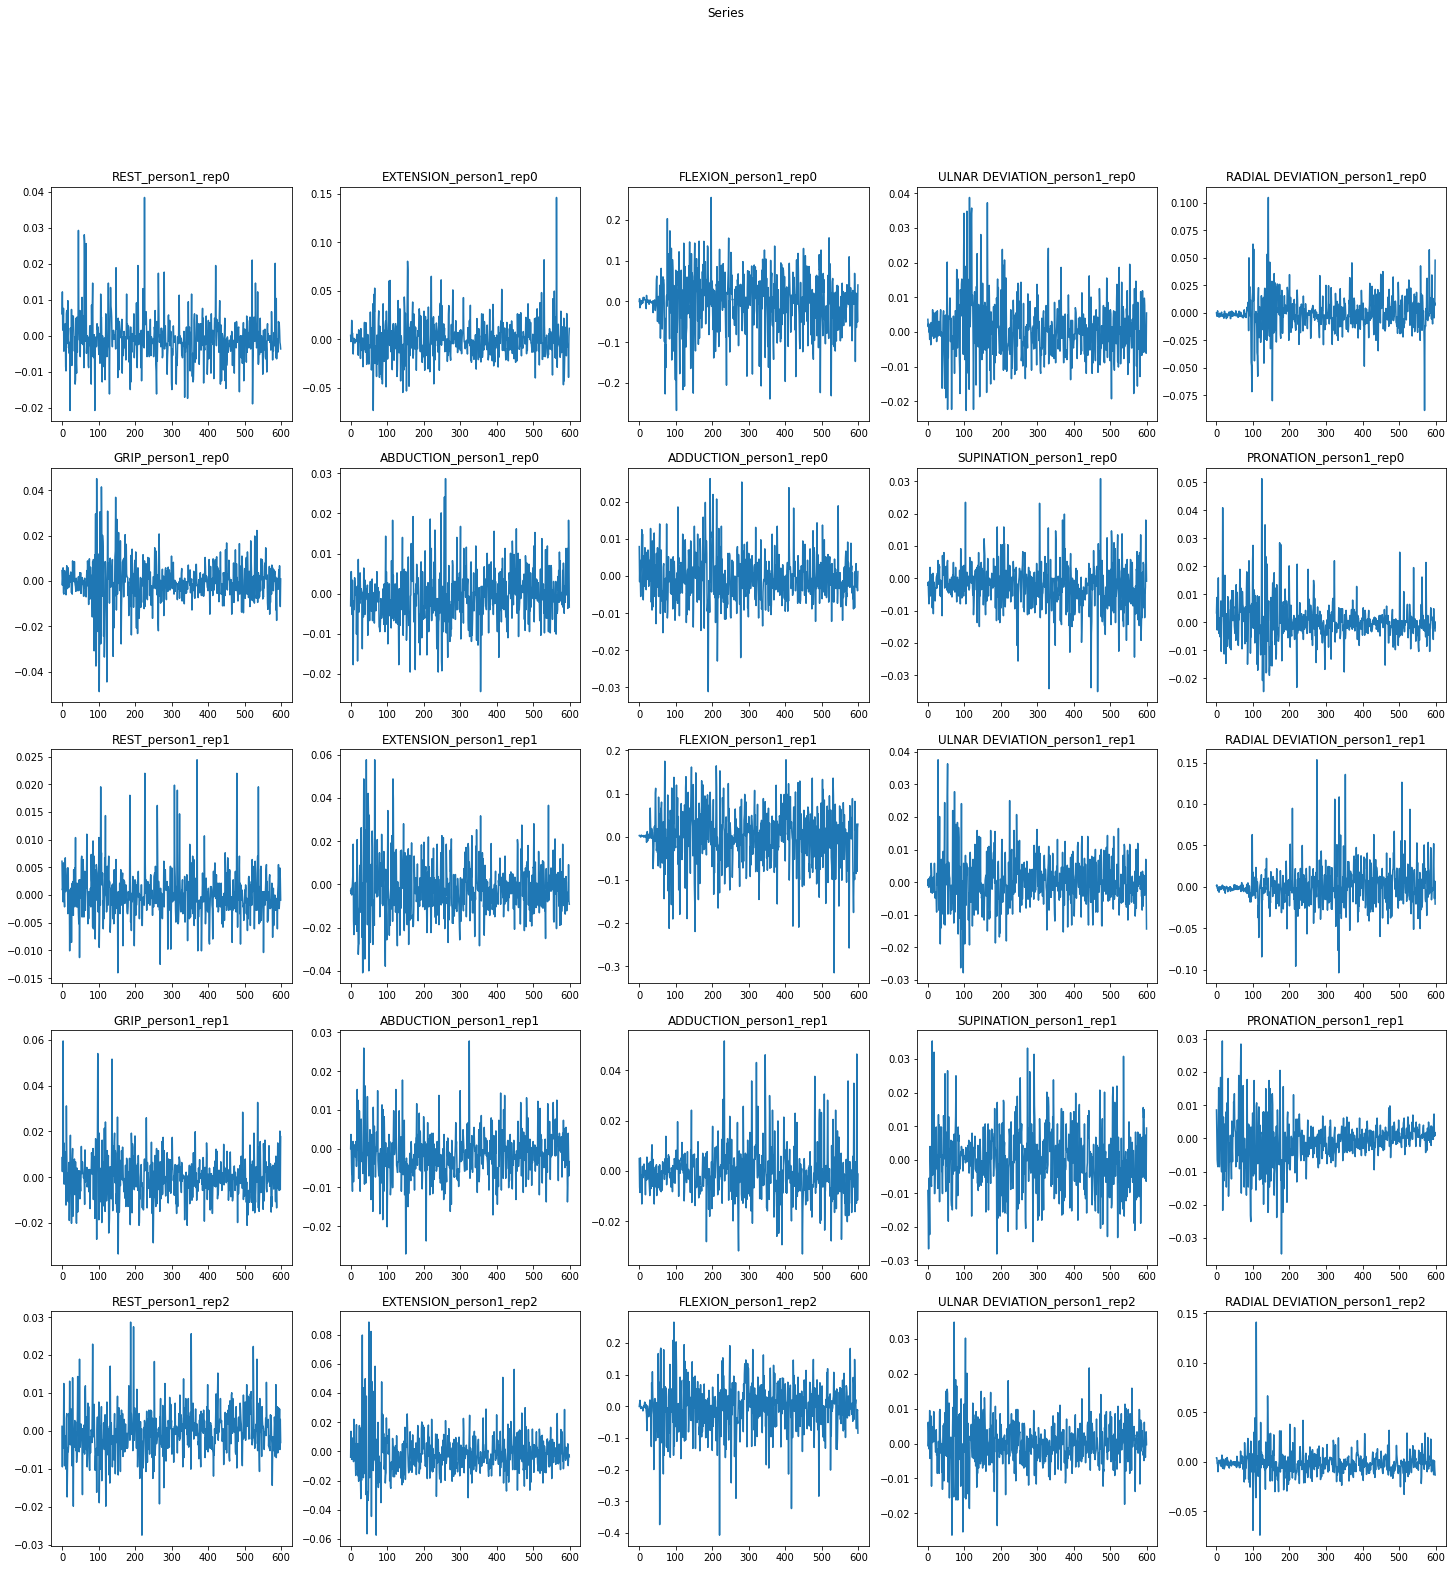

In [90]:
fig, axs = plt.subplots(5,5,figsize=(25,25))
fig.suptitle('Series')
for i in range(5):
    for j in range(5):
        if i*5+j+1>len(mySeries): 
            continue
        axs[i, j].plot(mySeries[i*5+j])
        axs[i, j].set_title(namesofMySeries[i*5+j])
plt.show()

### Предобработка

In [73]:
# mySeries = TimeSeriesScalerMeanVariance().fit_transform(mySeries)

### KNN

In [91]:
np.random.seed(42)
cluster_count = 10
km = TimeSeriesKMeans(n_clusters=cluster_count, max_iter=100)
labels = km.fit_predict(mySeries)

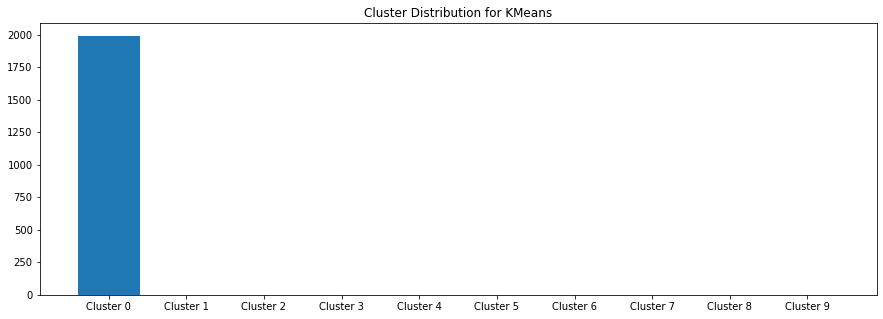

In [92]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [93]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
knn_result = pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),
             columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")
knn_result["Cluster"]

Series
REST_person1_rep0           Cluster 0
PRONATION_person27_rep3     Cluster 0
SUPINATION_person27_rep3    Cluster 0
ADDUCTION_person27_rep3     Cluster 0
ABDUCTION_person27_rep3     Cluster 0
                              ...    
FLEXION_person17_rep2       Cluster 5
FLEXION_person19_rep2       Cluster 6
FLEXION_person22_rep3       Cluster 7
FLEXION_person4_rep0        Cluster 8
FLEXION_person36_rep4       Cluster 9
Name: Cluster, Length: 2000, dtype: object

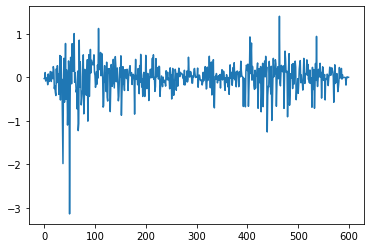

In [94]:
plt.plot(mySeries[namesofMySeries.index("FLEXION_person17_rep2")])

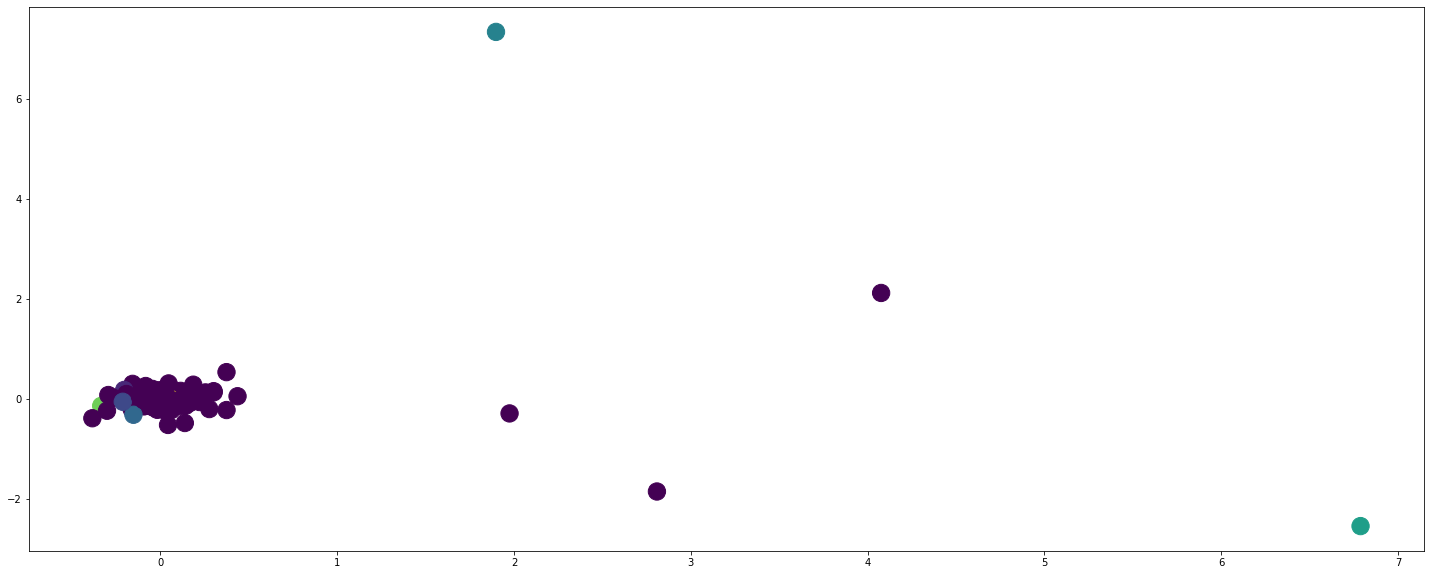

In [95]:
pca = PCA(n_components=2)
mySeries_transformed = pca.fit_transform(mySeries)

plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:,0],mySeries_transformed[:,1], s=300, c=labels)
plt.show()